In [33]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

from RMS.Astrometry.ApplyAstrometry import xyToRaDecPP
from RMS.Astrometry.Conversions import trueRaDec2ApparentAltAz
from RMS.Formats.Platepar import Platepar
from RMS.Math import angularSeparation

import pyximport
from RMS.Astrometry.CyFunctions import equatorialCoordPrecession

Max angular separation between hour 0 and hour 12: 0.00 arcminutes
0.0028964601780708103


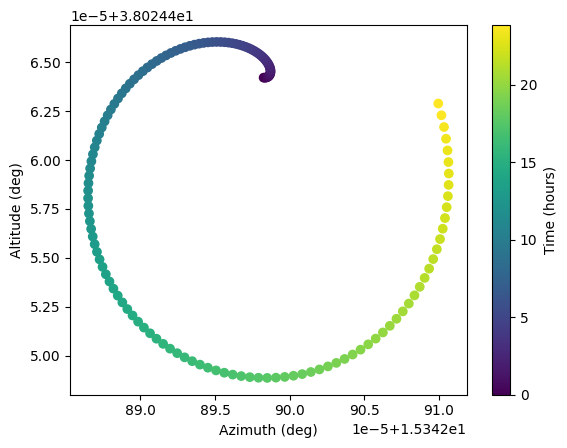

Max angular separation between hour 0 and hour 12: 12.59 arcminutes
54.597536869519324


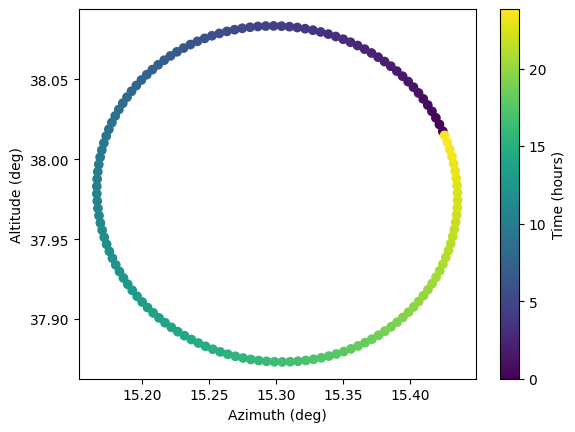

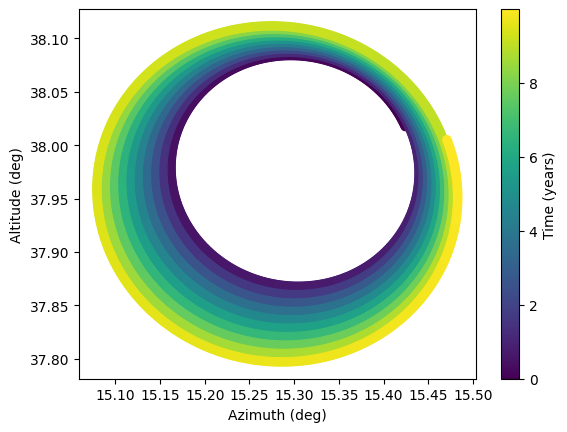

: 

In [44]:
# Load the platepar files
dir_path = r"C:\Users\denis\Dropbox\RPi_Meteor_Station\code_testing\precession_correction_j2000"
pp_reference_file = "platepar_cmn2010.cal"
pp_recalibrated_file = "platepars_all_recalibrated.json"

# Load the reference platepar file
pp = Platepar()
pp.read(os.path.join(dir_path, pp_reference_file))

# Load the recalibrated platepar file
with open(os.path.join(dir_path, pp_recalibrated_file)) as f:
    recalibrated_platepars = json.load(f)

    # Load platepar objects from the json file
    pp_recalibrated = []
    for ff_ref in recalibrated_platepars:
        pp_dict = recalibrated_platepars[ff_ref]
        pp_temp = Platepar()
        pp_temp.loadFromDict(pp_dict)
        pp_recalibrated.append(pp_temp)


# Compute the pointing drift
pointing_drift = []
for pp_temp in pp_recalibrated:
    
    ang_sep = np.degrees(angularSeparation(np.radians(pp.RA_d), np.radians(pp.dec_d), np.radians(pp_temp.RA_d), np.radians(pp_temp.dec_d)))

    # print(ang_sep)



# Compute the total precession in equatorial coordinates of the center of the field of view defined
# in the platepar
# Investigate how the precession changes over 24 hours, depending on the FOV pointing
jd_j2000 = 2451545.0
data = []
for jd_frac in np.arange(0, 1, 10/60/24):

    # Compute the JD
    jd = pp.JD + jd_frac

    fov_centre_x = pp.X_res/2
    fov_centre_y = pp.Y_res/2

    # Compute the RA/Dec of the centre of the field of view
    _, ra, dec, _ = xyToRaDecPP([jd], [fov_centre_x], [fov_centre_y], [1], pp, jd_time=True)


    ra_prec, dec_prec = equatorialCoordPrecession(pp.JD, jd_j2000, np.radians(ra[0]), np.radians(dec[0]))
    delta_ra_prec = np.degrees(ra_prec) - ra[0]
    delta_dec_prec = np.degrees(dec_prec) - dec[0]

    # print("Total precession diff:")
    # print("RA  = {:.3f} deg".format(delta_ra_prec))
    # print("Dec = {:.3f} deg".format(delta_dec_prec))
    # print("Total = {:.2f} arcmin".format(60*np.hypot(delta_ra_prec, delta_dec_prec)))

    # Compute the apparent alt/az from the precession corrected-coordinates
    az, alt = trueRaDec2ApparentAltAz(np.degrees(ra_prec), np.degrees(dec_prec), jd, pp.lat, pp.lon, pp.refraction)

    data.append([jd, az, alt])

# Plot the data
data = np.array(data)
jd_data, az_data, alt_data = data.T

# Compute the angular difference between hour 0 and hour 12 in arcminutes
az_mid = az_data[len(az_data)//2]
alt_mid = alt_data[len(alt_data)//2]
ang_sep_max = np.degrees(angularSeparation(np.radians(az_data[0]), np.radians(alt_data[0]), np.radians(az_mid), np.radians(alt_mid)))*60

print("Max angular separation between hour 0 and hour 12: {:.2f} arcminutes".format(ang_sep_max))
print(ang_sep_max/np.cos(np.radians(pp.dec_d)))


plt.scatter(az_data, alt_data, c=(jd_data - np.min(jd_data))*24)
plt.xlabel("Azimuth (deg)")
plt.ylabel("Altitude (deg)")
plt.colorbar(label="Time (hours)")
plt.show()





# For 24 hours, plot apparent alt/az of the centre of the field of view every 10 minutes
ref_jd = pp.JD
data = []
for jd_frac in np.arange(0, 1, 10/60/24):

    # Compute the JD
    jd = ref_jd + jd_frac

    fov_centre_x = pp.X_res/2
    fov_centre_y = pp.Y_res/2

    # Compute the RA/Dec of the centre of the field of view
    _, ra, dec, _ = xyToRaDecPP([jd], [fov_centre_x], [fov_centre_y], [1], pp, jd_time=True)

    # Compute the apparent alt/az
    az, alt = trueRaDec2ApparentAltAz(ra[0], dec[0], jd, pp.lat, pp.lon, pp.refraction)

    data.append([jd, az, alt])


# Plot the data
data = np.array(data)
jd_data, az_data, alt_data = data.T

# Compute the angular difference between hour 0 and hour 12 in arcminutes
az_mid = az_data[len(az_data)//2]
alt_mid = alt_data[len(alt_data)//2]
ang_sep_max = np.degrees(angularSeparation(np.radians(az_data[0]), np.radians(alt_data[0]), np.radians(az_mid), np.radians(alt_mid)))*60

print("Max angular separation between hour 0 and hour 12: {:.2f} arcminutes".format(ang_sep_max))
print(ang_sep_max/np.cos(np.radians(pp.dec_d)))

plt.scatter(az_data, alt_data, c=(jd_data - np.min(jd_data))*24)
plt.xlabel("Azimuth (deg)")
plt.ylabel("Altitude (deg)")
plt.colorbar(label="Time (hours)")
plt.show()


# Make a plot covering 10 years, one point each day
data = []
for jd_frac in np.arange(0, 365*10, 1):

    # Compute the JD
    jd = ref_jd + jd_frac

    fov_centre_x = pp.X_res/2
    fov_centre_y = pp.Y_res/2

    # Compute the RA/Dec of the centre of the field of view
    _, ra, dec, _ = xyToRaDecPP([jd], [fov_centre_x], [fov_centre_y], [1], pp, jd_time=True)

    # Compute the apparent alt/az
    az, alt = trueRaDec2ApparentAltAz(ra[0], dec[0], jd, pp.lat, pp.lon, pp.refraction)

    data.append([jd, az, alt])


# Plot the data
data = np.array(data)
jd_data, az_data, alt_data = data.T

plt.scatter(az_data, alt_data, c=(jd_data - np.min(jd_data))/365)
plt.xlabel("Azimuth (deg)")
plt.ylabel("Altitude (deg)")
plt.colorbar(label="Time (years)")
plt.show()

